In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:100% !important;}</style>'))

In [5]:
%matplotlib notebook
import matplotlib.pyplot as plt 
import numpy as np
import torch

import nmf.mult
import nmf.pgrad
import nmf.nesterov

import nmf_torch.mult
import nmf_torch.pgrad
import nmf_torch.nesterov
import nmf_torch.norms

import pickle

from theory.represent import rescale_WH

from read_data.reading import read_indian_pines, images_matrix_grid,\
                                roll_images, unroll_images 

from performance.performance_eval_func import get_random_lowrank_matrix, get_time_ratio,\
                      compare_performance, plot_errors_dict,\
                      torch_algo_wrapper,\
                      plot_ratios_gpu_algo, plot_ratios_cpu_gpu, plot_ratios_cpu_algo,\
                      errors_at_time_t_over_inner_dim
                                                

In [6]:
import importlib, performance.performance_eval_func
importlib.reload(performance.performance_eval_func)

<module 'performance.performance_eval_func' from '/home/aiadmin/maxim/pytorch_project/finalYearProjectNMF/performance/performance_eval_func.py'>

In [7]:
! git pull

Already up to date.


In [8]:
from matplotlib.gridspec import GridSpec
from matplotlib.image import AxesImage
import matplotlib.widgets as widgets


class InteractiveLandPlot:
    def __init__(self, gt_data, H, ori_shape):
        gs = GridSpec(2, 4, width_ratios=[2, 10, 10, 2], height_ratios=[10, 1])

        self.maps_fig = plt.figure(figsize=(5, 4))
        self.maps_ax = plt.subplot(gs[0, 2:])
        self.btn_less_ax = plt.subplot(gs[1, 0])
        self.slider_ax = plt.subplot(gs[1, 1:3])
        self.btn_more_ax = plt.subplot(gs[1, 3])
        self.maps_ax.set_title("Where the ith type appears")

        self.gt_ax = plt.subplot(gs[0, :2], sharex=self.maps_ax, 
                                  sharey=self.maps_ax)
         
        self.gt_ax.imshow(gt_data, cmap="nipy_spectral")
        self.gt_ax.set_title("Ground truth")      
            
        self.maps = roll_images(H, ori_shape)

        self.slider = widgets.Slider(self.slider_ax,
                                     label="",
                                     valmin=0,
                                     valmax=len(self.maps) - 1,
                                     valfmt='%0.0f',
                                     valstep=1)
        self.slider.on_changed(self.on_slider_move)

        self.btn_less = widgets.Button(self.btn_less_ax, "<<")
        self.btn_less.on_clicked(lambda e: self.set_slider_val(self.slider.val - 1))

        self.btn_more = widgets.Button(self.btn_more_ax, ">>")
        self.btn_more.on_clicked(lambda e: self.set_slider_val(self.slider.val + 1))
        
        self.on_slider_move(0)

    def set_slider_val(self, val):
        val = np.clip(val, self.slider.valmin, self.slider.valmax)
        self.slider.set_val(val)

    def on_slider_move(self, val):
        self.plot_ith_term(int(val))

    def plot_ith_term(self, i):
        for artist in self.maps_ax.get_children():
            if isinstance(artist, AxesImage): artist.remove()

        self.maps_ax.imshow(self.maps[i], zorder=0)
        self.maps_fig.canvas.draw()

In [9]:
algo_dict_to_test = {
    "mult": nmf.mult.factorise_Fnorm,
    "pgrad": nmf.pgrad.factorise_Fnorm_subproblems,
    "nesterov": nmf.nesterov.factorise_Fnorm,

    "mult_torch": torch_algo_wrapper(nmf_torch.mult.factorise_Fnorm, 
                                     device="cuda"),
    "pgrad_torch": torch_algo_wrapper(nmf_torch.pgrad.factorise_Fnorm_subproblems, 
                                      device="cuda"),
    "nesterov_torch": torch_algo_wrapper(nmf_torch.nesterov.factorise_Fnorm, 
                                        device="cuda")
}

In [10]:
indian_pines_data = read_indian_pines("data/indian_pines/images/")

In [11]:
indian_pines_data.keys()

dict_keys(['ns_line_im', 'ns_line_gt_im', 'site3_im', 'site3_gt_im'])

<IPython.core.display.Javascript object>


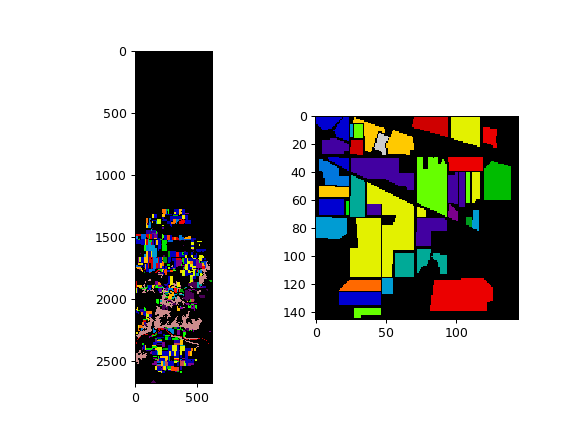

In [12]:
site3_im = indian_pines_data["site3_im"]
ns_line_im = indian_pines_data["ns_line_im"]
site3_gt_im = indian_pines_data["site3_gt_im"]
ns_line_gt_im = indian_pines_data["ns_line_gt_im"]

plt.figure()
plt.subplot(121)
plt.imshow(ns_line_gt_im, cmap="nipy_spectral")
plt.subplot(122)
plt.imshow(site3_gt_im, cmap="nipy_spectral")

In [13]:
site3_unrolled_data, site3_ori_shape = unroll_images(site3_im)
ns_line_unrolled_data, ns_line_ori_shape = unroll_images(ns_line_im)

In [59]:
ns_line_unrolled_data.nbytes / 2**30

2.6952046155929565

In [14]:
print(len(set(site3_gt_im.ravel())))
print(len(set(ns_line_gt_im.ravel())))

17
59


In [ ]:
plt.ioff()

for i,im in enumerate(site3_im):
    f, ax = plt.subplots()
    title = "{:03d}".format(i)
    ax.set_title(title)
    ax.imshow(im, cmap="gray")
    ax.axis('off')
    f.savefig("data/indian_pines/site3/" + title + ".png", bbox_inches='tight')
    plt.close(f)
    
plt.ion()   

In [ ]:
InteractiveLandPlot(site3_gt_im, site3_unrolled_data, site3_ori_shape)

# Site 3

In [ ]:
errors_over_r_site3 = pickle.load(open("errors_over_r_site3.pkl","rb"))

In [ ]:
errors_over_r_site3 = errors_at_time_t_over_inner_dim(
                            site3_unrolled_data, range(5, 35, 2),
                            30, {"nesterov_torch":algo_dict_to_test["nesterov_torch"]})

In [ ]:
pickle.dump(errors_over_r_site3,  open("errors_over_r_site3.pkl","wb"))

In [ ]:
f, ax = plt.subplots()
plot_errors_dict(errors_over_r_site3, ax, log=True, x_lbl="Inner dim", title="site3")

In [37]:
site3_errors = pickle.load(open("site3_data_errors_dict.pkl","rb"))

In [39]:
shape = site3_unrolled_data.shape
inner_dim=24

In [ ]:
W_init = np.random.rand(shape[0], inner_dim)
H_init = np.random.rand(inner_dim, shape[1])

site3_errors = compare_performance(V=site3_unrolled_data, 
                                  inner_dim=inner_dim, time_limit=240,
                                  W_init=W_init, H_init=H_init, 
                                  algo_dict_to_test=algo_dict_to_test)

In [ ]:
pickle.dump(site3_errors,  open("site3_data_errors_dict.pkl","wb"))

<IPython.core.display.Javascript object>


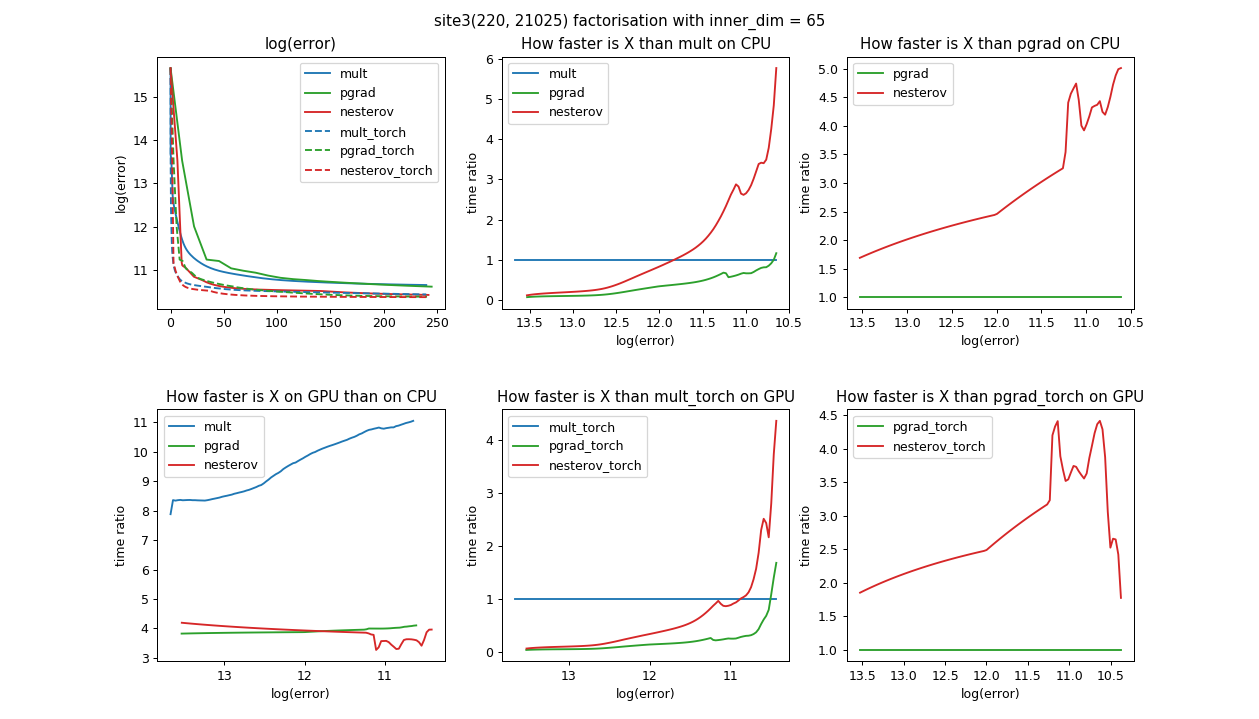

In [62]:
f, axs = plt.subplots(2, 3, figsize=(14, 8), gridspec_kw=dict(hspace=0.4, top=0.92, bottom=0.08))

f.suptitle("site3{} factorisation with inner_dim = {}".format(site3_unrolled_data.shape, inner_dim))
axs[0, 0].set_title("log(error)")
plot_errors_dict(site3_errors, axs[0, 0], log=True)

plot_ratios_cpu_gpu(site3_errors, axs[1, 0])
plot_ratios_cpu_algo(site3_errors, axs[0, 1:], selected_algs=["mult", "pgrad", "nesterov"])
plot_ratios_gpu_algo(site3_errors, axs[1, 1:], selected_algs=["mult_torch", "pgrad_torch", "nesterov_torch"])

In [ ]:
?plot_performance_dict

In [15]:
W_site3, H_site3 = torch_algo_wrapper(nmf_torch.nesterov.factorise_Fnorm)(
    V=site3_unrolled_data, inner_dim=25, 
    time_limit=60, epsilon=1e-6, max_steps=10000)

In [16]:
W_site3, H_site3 = rescale_WH(W_site3, H_site3)

<IPython.core.display.Javascript object>


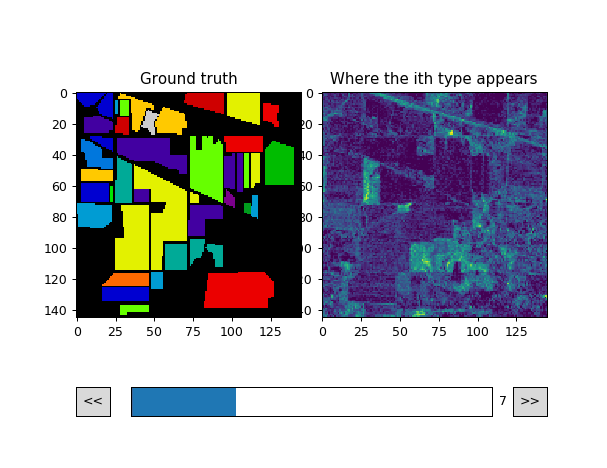

In [17]:
InteractiveLandPlot(site3_gt_im, H_site3, site3_ori_shape)

In [19]:
site3_results = roll_images(H_site3, site3_ori_shape)

<IPython.core.display.Javascript object>


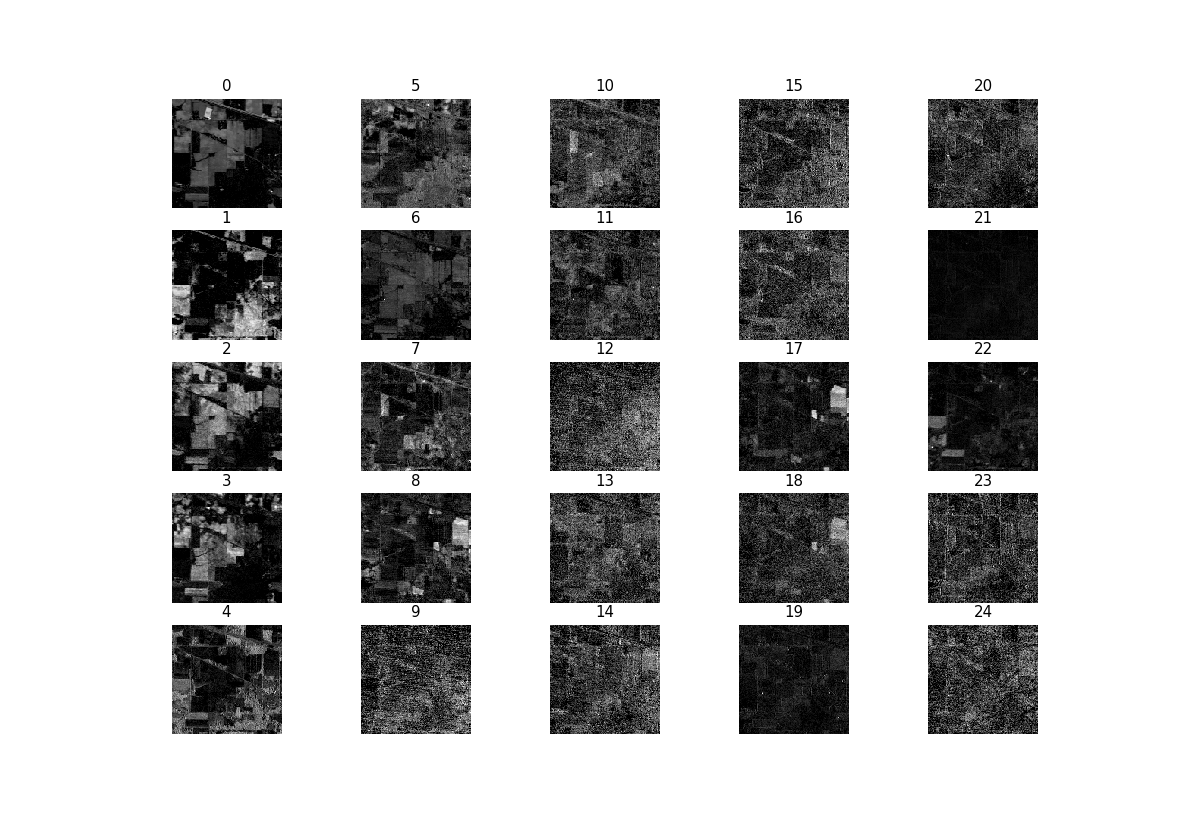

In [22]:
f, axs = plt.subplots(5, 5)
    
for i in range(25):
    ax = axs[i % 5, i // 5]
    ax.imshow(site3_results[i], cmap="gray"); 
    ax.axis('off'); 
    ax.set_title(i)

<IPython.core.display.Javascript object>


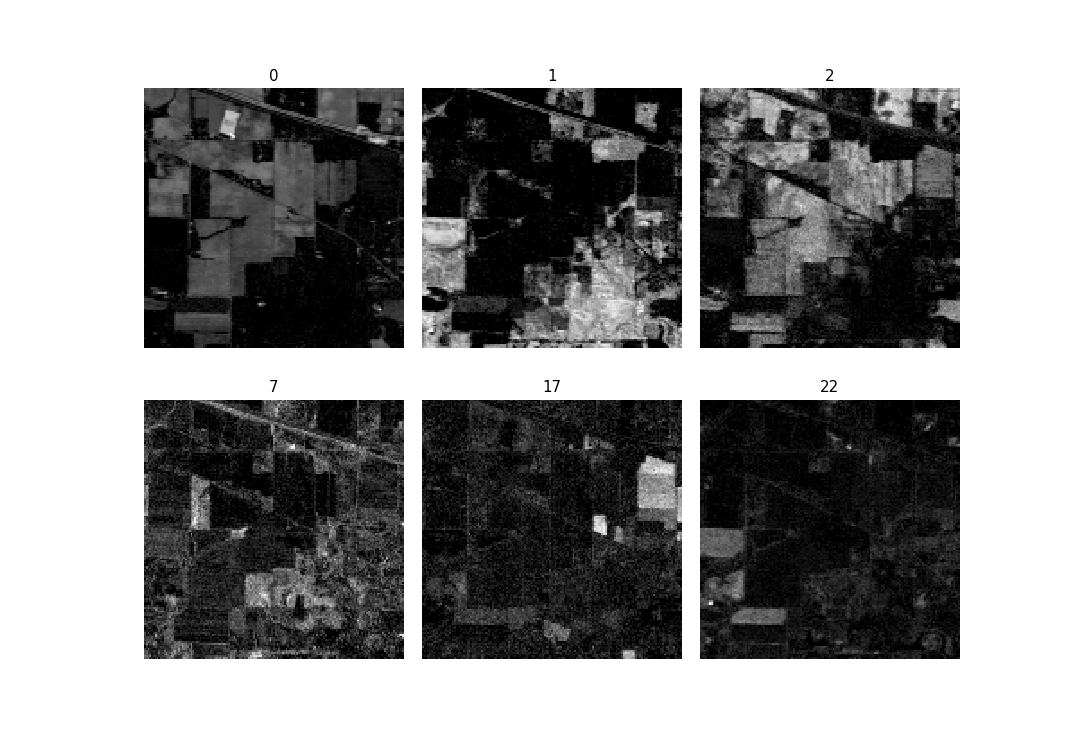

In [36]:
l = [0, 1, 2, 7, 17, 22]
f, axs = plt.subplots(2, 3, gridspec_kw=dict(wspace=0))
axs = axs.ravel()
for i, idx in enumerate(l):
    ax = axs[i]
    ax.imshow(site3_results[idx], cmap="gray"); 
    ax.axis('off'); 
    ax.set_title(idx)
    


# N-S Line

In [ ]:
errors_over_r_ns_line = pickle.load(open("errors_over_r_ns_line.pkl","rb"))

In [ ]:
errors_over_r_ns_line = errors_at_time_t_over_inner_dim(
                            ns_line_unrolled_data.astype(np.float32), range(50, 80, 2),
                            30, {"nesterov_torch":algo_dict_to_test["nesterov_torch"]})

In [ ]:
pickle.dump(errors_over_r_ns_line,  open("errors_over_r_ns_line.pkl","wb"))

In [ ]:
f, ax = plt.subplots()
plot_errors_dict(errors_over_r_ns_line, ax, log=True, x_lbl="Inner dim", title="ns_line")

In [48]:
ns_line_errors = pickle.load(open("ns_line_data_errors_dict.pkl","rb"))

In [46]:
shape = ns_line_unrolled_data.shape
inner_dim=65

In [ ]:


W_init = np.random.rand(shape[0], inner_dim).astype(np.float32)
H_init = np.random.rand(inner_dim, shape[1]).astype(np.float32)

ns_line_errors = compare_performance(V=ns_line_unrolled_data.astype(np.float32), 
                                     inner_dim=inner_dim, time_limit=1200,
                                     W_init=W_init, H_init=H_init, 
                                     algo_dict_to_test=algo_dict_to_test)

In [47]:
pickle.dump(ns_line_errors,  open("ns_line_data_errors_dict.pkl","wb"))

NameError: name 'ns_line_errors' is not defined

<IPython.core.display.Javascript object>


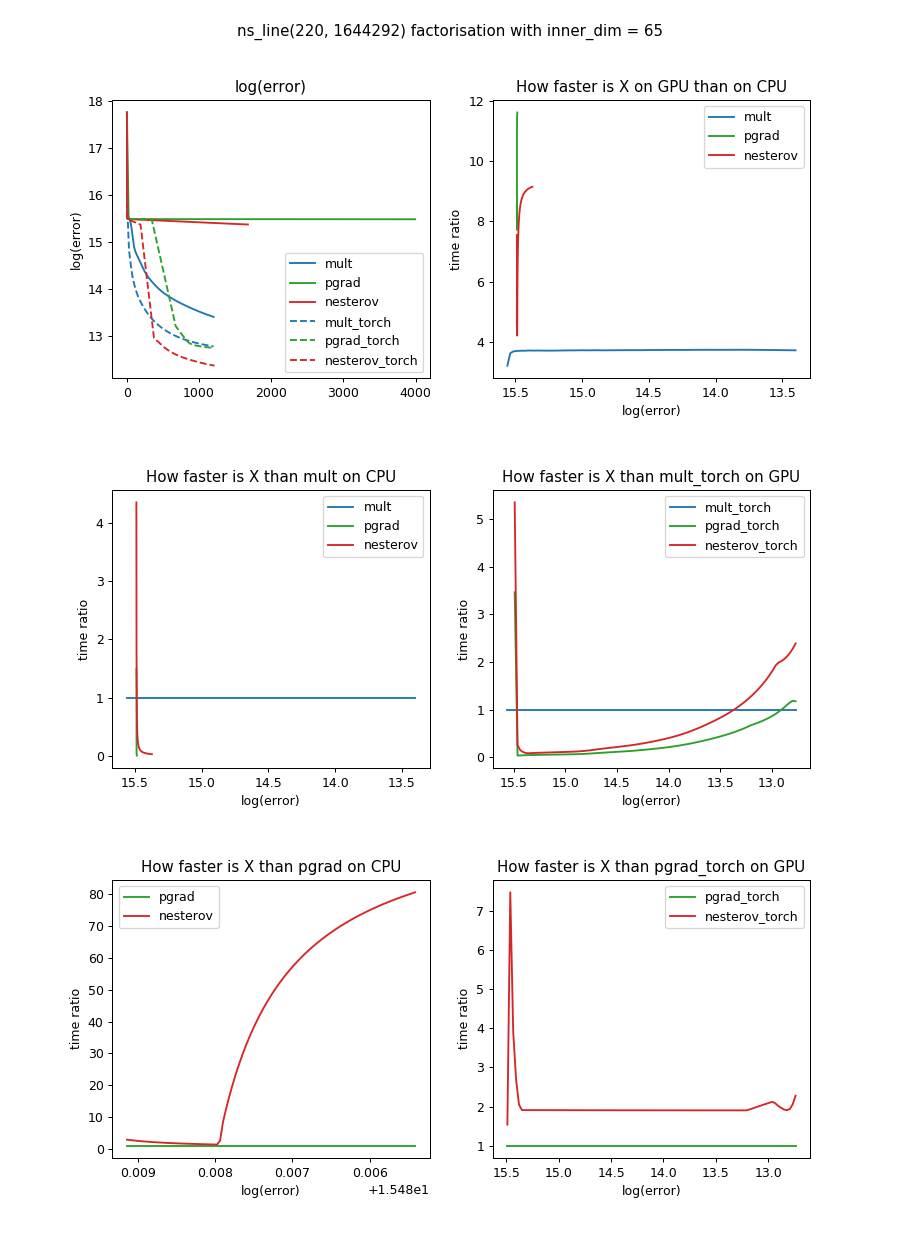

In [53]:
f, axs = plt.subplots(3, 2, figsize=(10, 14), gridspec_kw=dict(hspace=0.4, top=0.92, bottom=0.08))
f.suptitle("ns_line{} factorisation with inner_dim = {}".format(ns_line_unrolled_data.shape, inner_dim))
axs[0, 0].set_title("log(error)")

plot_errors_dict(ns_line_errors, axs[0, 0], log=True)
plot_ratios_cpu_gpu(ns_line_errors, axs[0, 1])
plot_ratios_cpu_algo(ns_line_errors, axs[1:, 0], selected_algs=["mult", "pgrad", "nesterov"])
plot_ratios_gpu_algo(ns_line_errors, axs[1:, 1], selected_algs=["mult_torch", "pgrad_torch", "nesterov_torch"])

In [ ]:
W_ns_line, H_ns_line = nmf.nesterov.factorise_Fnorm(
    V=ns_line_unrolled_data.astype(np.float32), inner_dim=70, 
    time_limit=60, epsilon=1e-6, max_steps=10000)

In [ ]:
InteractiveLandPlot(ns_line_gt_im, H_ns_line, ns_line_ori_shape)